# Autoencoder Convolucional SPM1 Dos capas - HH

Modelo convolucional entrenado con imágenes polares de la sección eficaz - $\sigma(\hat{k}_x, \hat{k}_y)$ - para el problema de dos capas en la aproximación SPM1.

### Cargamos los modelos de scattering y generamos los datos



In [1]:
# Importo el modelo desarrollado por Marian: ecuación (27) del paper de Moghaddam.
from spm1 import S01HH
from spm1 import S01VV
from spm1 import S01HV
from spm1 import kix
from spm1 import kiy

In [51]:
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

# Parámetros fijos
acf = 1
realizations = 30000

# Generamos los parámetros que vamos a variar aleatoriamente
k0 = 2*pi/.25
d = np.linspace(.5, 1.5, 50)
ep1, ep2 = np.arange(3, 53), np.arange(3, 53)
s1, s2 = np.linspace(.005, .025, 50), np.linspace(.005, .025, 50)
l1, l2 = np.linspace(.05, .25, 50), np.linspace(.05, .25, 50)
theta_i, phi_i = 45*np.pi/180, 0*np.pi/180 

# Parámetros para recorrer
theta, phi = np.linspace(1e-5, 89, 30)*np.pi/180, np.linspace(0, 360, 30)*np.pi/180 
THETA, PHI = np.meshgrid(theta, phi)

kx = np.sin(THETA)*np.cos(PHI)
ky = np.sin(THETA)*np.sin(PHI)

# Sampleo y recorro: generamos un vector aleatorio que contenga los índices de los argumentos
rng = np.random.default_rng()
sigma = np.zeros((realizations, PHI.shape[0], PHI.shape[1]))

# Defino una función para normalizar los datos
def MinMax(tensor):
    return (tensor - np.min(tensor)) / (np.max(tensor) - np.min(tensor))

for i in range(realizations):
  # Genero una tira de indices aleatorios
  index = rng.integers(50, size=10)
  
  # Calculo el vector de onda incidente parallelo 
  kx_i = kix(k0, theta_i, phi_i)
  ky_i = kiy(k0, theta_i, phi_i)
  k1 = kx - kx_i
  k2 = ky - ky_i

  # Armo una tupla con los argumentos de S01     
  args = (k0, theta_i, phi_i,
           THETA, PHI, 
           ep1[index[0]], ep2[index[1]],
           d[index[2]], s1[index[3]], l1[index[4]],
           s2[index[5]], l2[index[6]],
           k1, k2, acf)
  
  # Calculo la sección eficaz y agrego ruido
  # h-pol
  s_hh = S01HH(*args)
  s_hh_noise = s_hh + rng.normal(0, .03*np.mean(s_hh), size = PHI.shape)

  # Guardo los resultados en un tensor: primero apilo los tres canales (stack)
  cond = np.count_nonzero(np.isnan(s_hh_noise))              # Cuenta cantidad de NaNs
  
  if cond == 0: 
      sigma[i,:,:] = MinMax(s_hh_noise)
 

/home/jotavecorta/proyectos/tesis/src/DLSM/small_perturbation_method/spm1.py:97: RuntimeWarning: divide by zero encountered in true_divide
  return (2*kiz(k0,thi))/(-k1zi(k0,thi,ep1) + kiz(k0,thi) + ((k1zi(k0,thi,ep1) + k2zi(k0,thi,ep2))*(k1zi(k0,thi,ep1) + kiz(k0,thi)))/(exp(2*1j*d*k1zi(k0,thi,ep1))*(k1zi(k0,thi,ep1) - k2zi(k0,thi,ep2))))
/home/jotavecorta/proyectos/tesis/src/DLSM/small_perturbation_method/spm1.py:97: RuntimeWarning: invalid value encountered in true_divide
  return (2*kiz(k0,thi))/(-k1zi(k0,thi,ep1) + kiz(k0,thi) + ((k1zi(k0,thi,ep1) + k2zi(k0,thi,ep2))*(k1zi(k0,thi,ep1) + kiz(k0,thi)))/(exp(2*1j*d*k1zi(k0,thi,ep1))*(k1zi(k0,thi,ep1) - k2zi(k0,thi,ep2))))


In [52]:
# Chequeo el tamaño de los datos
shape = sigma.shape
print(f'Tamaños de los datos originales: {shape}')

Tamaños de los datos originales: (30000, 30, 30)


### Visualizo las soluciones generadas

(-1.0, 1.0)

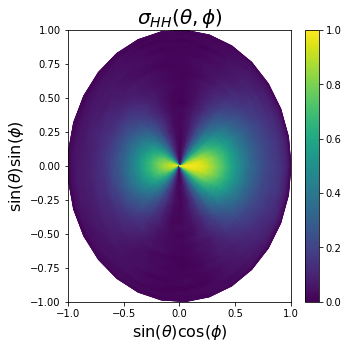

In [53]:
# Elijo una imagen al azar
index = rng.integers(shape[0]) 
img = sigma[index, :, :]


fig = plt.figure(figsize=(5, 5))

ax = plt.subplot()
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

### Preparo los datos y defino el Autoencoder

In [54]:
from sklearn.model_selection import train_test_split

# Chequeo que no haya NaNs
print(f'Cantidad de NaNs en sigma: {np.count_nonzero(np.isnan(sigma))}')

# Separo en conjuntos de entrenamiento y testeo
sigma_train, sigma_test = train_test_split(sigma, test_size=.2)
print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

Cantidad de NaNs en sigma: 0
Tamaño de los datos de entrenamiento: (24000, 30, 30)
Tamaño de los datos de testeo: (6000, 30, 30)


Visualizo los elementos del conjuto de entrenamiento

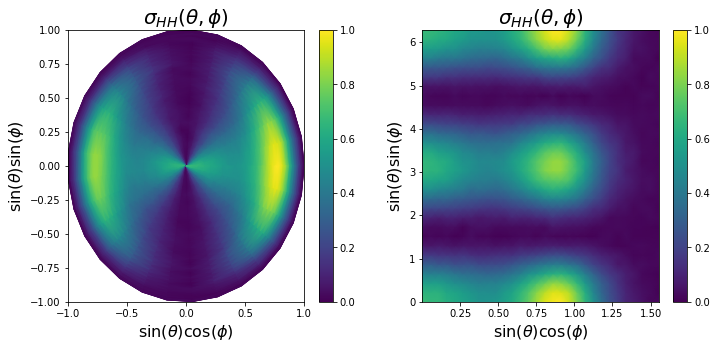

In [13]:
index = rng.integers(sigma_test.shape[0]) 
img = sigma_test[index,:,:]


fig = plt.figure(figsize=(18, 5))
# Canal HH
ax = plt.subplot(1, 3, 1)
c = ax.pcolormesh(kx, ky, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)
plt.xlim((-1,1))
plt.ylim((-1,1))

# grafico cartesiano
ax = plt.subplot(1, 3, 2)
c = ax.pcolormesh(THETA, PHI, img,
                  shading = 'gouraud' )
plt.title(r'$\sigma_{HH}(\theta,\phi)$', fontsize = 20)
plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 16)
plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 16)
fig.colorbar(c, ax=ax)


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class ConvAutoencoder(Model):
    
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([layers.InputLayer(input_shape = (30,30,1)), 
                                            layers.Conv2D(4, (7, 7), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(8, (5, 5), strides=1, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Conv2D(8, (3, 3), strides=2, activation = 'relu'),
                                            layers.MaxPooling2D((2, 2), strides=1, padding = 'same'),
                                            
                                            layers.Flatten(),
                                            
                                            layers.Dense(units=9*9*8, activation='relu'),
                                            layers.Dense(units=256, activation='relu'),
                                            layers.Dense(units=64, activation='relu'),

                                            layers.Dense(latent_dim, activation = 'linear')])
      
        
        self.decoder = tf.keras.Sequential([layers.InputLayer(input_shape=(latent_dim,)),

                                            layers.Dense(units=64, activation='relu'),
                                            layers.Dense(units=256, activation='relu'),
                                            layers.Dense(units=9*9*8, activation='relu'),
                                            
                                            layers.Reshape(target_shape=(9,9,8)),
                                            
                                            layers.Conv2DTranspose(8, (4, 4), strides=2, activation="relu"),
                                            
                                            layers.Conv2DTranspose(8, (5, 5), strides=1, activation="relu"),

                                            layers.Conv2DTranspose(4, (7, 7), strides=1, activation='relu'),

                                            layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
  
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

2022-04-27 17:37:43.004236: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 17:37:43.004273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [63]:
autoencoder = ConvAutoencoder(2)
autoencoder.build(input_shape = (16000,30,30,1))
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 4)         200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 8)         808       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 648)               0

In [56]:
# Extiendo las dimensiones de sigma para ingresar al modelo
sigma_train, sigma_test = np.expand_dims(sigma_train, axis=-1), np.expand_dims(sigma_test, axis=-1)
print(f'Tamaño de los datos de entrenamiento: {sigma_train.shape}')
print(f'Tamaño de los datos de testeo: {sigma_test.shape}')

# Guardo el grupo de testeo para usar más tarde
folder = os.getcwd().split('/')[:-2]
file_name = "results/SPM_tl_test_set"

file_path = os.path.join("/".join(folder), file_name)
np.save(file_path, sigma_test)

Tamaño de los datos de entrenamiento: (24000, 30, 30, 1)
Tamaño de los datos de testeo: (6000, 30, 30, 1)


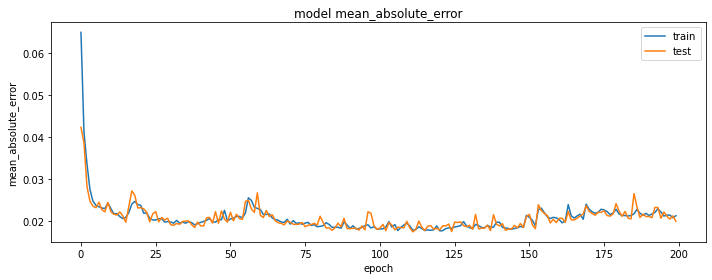

In [64]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])
history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 200,
            batch_size = 32,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))

# Visualizo el entrenamiento
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.tight_layout()
plt.show()

In [66]:
# Guardamos los pesos de la red entrenada
import os
file_name = 'results/weights_lat_2_spm_two_layer_HH.h5'
weights_path = os.path.join('/'.join(folder), file_name)
print(os.path.isdir(os.path.join("/".join(folder), "results")))
autoencoder.save_weights(weights_path)

True


# Visualizamos los resultados 

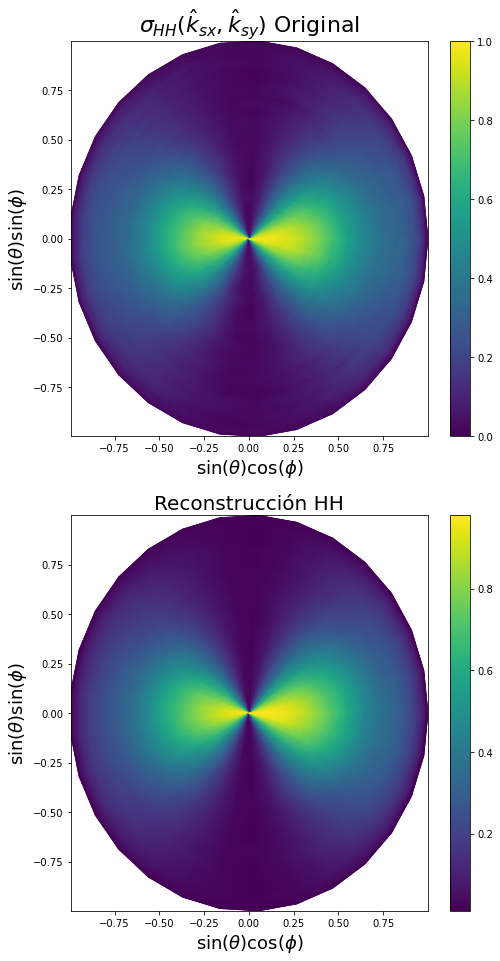

In [67]:
# Genero y decodifico imagenes de testeo
encoded_imgs = autoencoder.encoder(sigma_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 1
pol = {0: "HH", 1: "HV", 2: "VV"}
index = rng.integers(sigma_test.shape[0])

fig = plt.figure(figsize=(8, 16)) 
for i in range(n):
    # Imagen original
    s = sigma_test[index, :, :, 0]
    s_min, s_max = s.min(), s.max()
    ax = plt.subplot(2, n, i + 1)
    c1 = ax.pcolormesh(kx, ky, s, shading = 'gouraud')
    plt.title(f"$\sigma_{{{pol[i]}}}(\hat{{k}}_{{sx}},\hat{{k}}_{{sy}})$ Original", fontsize = 22)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c1, ax=ax)

    # Imagen reconstruida
    s_recons = decoded_imgs[index, :, :, 0]
    s_min, s_max = s_recons.min(), s_recons.max()
    ax = plt.subplot(2, n, i + 1 + n)
    c2 = ax.pcolormesh(kx, ky, s_recons, vmin=s_min,
                       vmax=s_max, shading = 'gouraud')
    plt.title(f"Reconstrucción {pol[i]}", fontsize = 20)
    plt.xlabel(r"$\sin(\theta)\cos(\phi)$", fontsize = 18)
    plt.ylabel(r"$\sin(\theta)\sin(\phi)$", fontsize = 18)
    ax.axis([kx.min(), kx.max(), ky.min(), ky.max()])
    fig.colorbar(c2, ax=ax)
plt.show()


In [62]:
# Libero espacio en memoria
tf.keras.backend.clear_session()
del autoencoder

## Variamos la dimensión del Espacio Latente

In [21]:
# Entreno varios autoencoders con distinta dim en espacio latente
min_abs_error, min_sqr_error  = [], []
avg_abs_error, avg_sqr_error = [], []

for lat_dim in range(1, 16):
  autoencoder = ConvAutoencoder(lat_dim)
  autoencoder.compile(optimizer = 'adam', loss = losses.MeanSquaredError(),
                    metrics = ['mean_absolute_error', 'mean_squared_error'])

  # Entreno el modelo
  history = autoencoder.fit(sigma_train, sigma_train,
            epochs = 150,
            batch_size = 64,
            verbose = 0,
            validation_data=(sigma_test, sigma_test))
  
  error_abs = np.array(history.history['val_mean_absolute_error'])
  error_sqr = np.array(history.history['val_mean_squared_error'])

  # Valor mínimo del error
  min_abs_error.append(error_abs.min())
  min_sqr_error.append(error_sqr.min())

  # Valor promedio del error en los ultimos 50 epochs
  avg_abs_error.append(np.mean(error_abs[-50:]))
  avg_sqr_error.append(np.mean(error_sqr[-50:]))

  # Elimino el modelo de la memoria
  tf.keras.backend.clear_session()
  del autoencoder

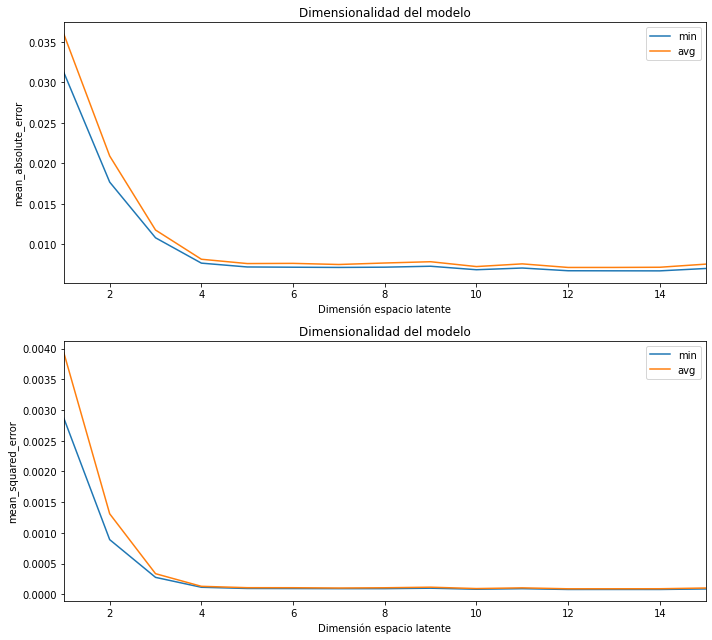

In [23]:
img_name = 'results/costo_SPM_two_layer_2_HH_ngi.png'
img_path = os.path.join('/'.join(folder), img_name)

# Visualizo los errores -  Mean Absolute error
plt.figure(figsize = (10,9))
plt.subplot(2,1,1)
plt.plot(range(1, 16), min_abs_error)
plt.plot(range(1, 16), avg_abs_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_absolute_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
 

# Mean Squared Error
plt.subplot(2,1,2)
plt.plot(range(1, 16), min_sqr_error)
plt.plot(range(1, 16), avg_sqr_error)
plt.title('Dimensionalidad del modelo')
plt.ylabel('mean_squared_error')
plt.xlabel('Dimensión espacio latente')
plt.xlim((1, 15))
plt.legend(['min', 'avg'])
plt.tight_layout()
plt.savefig(img_path)
plt.show() 

In [24]:
# Guardo los datos
import pickle
cost_dict = {'MSE': (min_sqr_error, avg_sqr_error), 
             'MAE': (min_abs_error, avg_abs_error)}

path = os.path.join('/'.join(folder), 'results/cost_SPM_two_layer_HH.pkl')             

with open(path, 'wb') as f:
  pickle.dump(cost_dict, f)

In [78]:
# Calculo la derivada segunda para encontrar el codo
diff_MSE = np.diff(cost_dict['MSE'], n=2, axis=1)
diff_MAE = np.diff(cost_dict['MAE'], n=2, axis=1)

print(f'Los índices que maximizan la curvatura para el error MAE son {np.argmax(diff_MAE, axis=1)}')
print(f'Los índices que maximizan la curvatura para el error MSE son {np.argmax(diff_MSE, axis=1)}')

[[ 6.64858986e-03  3.74260452e-03  2.65316758e-03  4.42083459e-04
   4.52017412e-06  5.77485189e-05  8.38828273e-05 -5.46279363e-04
   6.41922932e-04 -5.46673313e-04  3.27086542e-04  1.99116766e-06
   2.99374107e-04]
 [ 5.88882938e-03  5.52745243e-03  3.07150621e-03  5.54642370e-04
  -1.60813527e-04  3.21689723e-04 -2.59635691e-05 -7.54623096e-04
   9.29863732e-04 -7.75785102e-04  4.44795219e-04  2.10951548e-05
   3.61305345e-04]]
Los índices que maximizan la curvatura para el error MAE son [0 0]
Los índices que maximizan la curvatura para el error MSE son [0 0]
